# Initial analysis

In this notebook, we will do some initial analysis over the datasets `quotebank-china.json` and `speaker-attributes.parquet`, exploring them to get a feel of data.


In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

---

## quotebank-china

`quotebank-china.json` is a derived dataset we extract from the article-centric datasets from 2008 to 2020. It contains all the articles discussing about China, each pairing with a list of quotations. The extraction process can be found in `data_extraction.py`.

In [180]:
path_china_2020 = "data/quotebank-china-2020.json.bz2"
china_2020 = pd.read_json(path_china_2020, lines=True)

In [181]:
china_2020.shape

(477619, 14)

In [182]:
china_2020.head(5)

,quotationOffset,quoteID,numOccurrences,quotation,leftContext,rightContext,globalTopSpeaker,globalProbas,localTopSpeaker,localProbas,title,date,articleID,localTopSpeakerID
0,254,2020-02-17-002719,25,All of our stores in China and many of our par...,. IMF chief Kristalina Georgieva said there co...,it added. [QUOTE] New cases outside the epicen...,Kristalina Georgieva,"[[Kristalina Georgieva, 0.8555], [None, 0.1445]]",Kristalina Georgieva,"[[Kristalina Georgieva, 0.8576], [None, 0.1424]]",Apple says will not meet revenue forecasts due...,2020-02-17 22:39:03,2020021722_00241699_W,[Q265277]
1,223,2020-01-02-060856,1,"Three years into his presidency, Donald Trump ...",[QUOTE] Sherman went on to fault Trump for [QU...,she wrote. Protesters at the U.S. Embassy in B...,Wendy Sherman,"[[Wendy Sherman, 0.8968], [None, 0.0674], [Pre...",Wendy Sherman,"[[Wendy Sherman, 0.8968], [None, 0.0674], [Pre...",Top Obama official : Trump to blame for attack...,2020-01-02 14:33:10,2020010215_00036243_W,[Q4169153]
2,140,2020-02-18-006228,44,appears to show a decline in new cases,". However, the death toll crossed 2,000 in mai...",but any apparent trend [QUOTE],Tedros Adhanom Ghebreyesus,"[[Tedros Adhanom Ghebreyesus, 0.9334], [None, ...",Antonio Guterres,"[[Antonio Guterres, 0.6763], [None, 0.3237]]",Coronavirus LIVE updates : Death toll in China...,2020-02-19 02:56:43,2020021902_00173921_W,[Q311440]
3,113,2020-02-18-043485,527,is not out of control but it is a very dangero...,new cases of coronavirus in China's Hubei prov...,"Meanwhile, the World Health Organization (WHO)...",Antonio Guterres,"[[Antonio Guterres, 0.6463], [None, 0.2758], [...",Antonio Guterres,"[[Antonio Guterres, 0.9649], [None, 0.0351]]",Coronavirus LIVE updates : Death toll in China...,2020-02-19 02:56:43,2020021902_00173921_W,[Q311440]
4,128,2020-01-03-060037,1,The President will not interfere with that pre...,. Presidential spokesperson Salvador Panelo is...,he added. FEATURED STORIES NEWSINFO De Lima dr...,Leila de Lima,"[[Leila de Lima, 0.5106], [Salvador Panelo, 0....",Leila de Lima,"[[Leila de Lima, 0.5106], [Salvador Panelo, 0....",Duterte to let Congress handle ABS-CBN license...,2020-01-03 07:48:49,2020010308_00094284_W,[Q520173]


<AxesSubplot:xlabel='localTopSpeakerID', ylabel='count'>

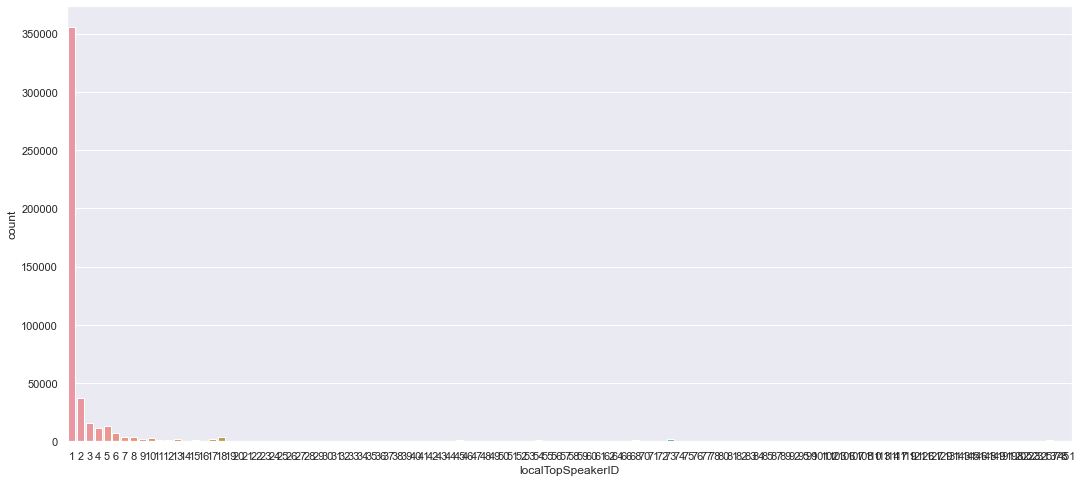

In [185]:
sns.set(rc={'figure.figsize':(18,8)})
sns.countplot(x=china_2020.localTopSpeakerID.apply(len))

- As we can see from above, most rows have unique speakerIDs while the rest have multiple ones. This is because some speakers may have identical names, which makes it difficult for us to associate these names with real speakers.
- For convenience, we decide to drop those lines with multiple localTopSpeakerIDs.

In [186]:
print("Before removing multiple localTopSpeakerIDs, we have %d rows" % len(china_2020))
china_2020 = china_2020[china_2020.localTopSpeakerID.apply(len)==1]
print("After removing multiple localTopSpeakerIDs, we have %d rows" % len(china_2020))

Many titles seem to be used by several sources. A plausible reason could be that these articles are reprinted multiple times.

In [90]:
print("Checking missing values...")
china_2020.isna().sum(axis=0)

Checking missing values...


quotationOffset           0
quoteID                   0
numOccurrences            0
quotation                 0
leftContext               0
rightContext              0
globalTopSpeaker          0
globalProbas              0
localTopSpeaker           0
localProbas               0
title                     0
date                      0
articleID                 0
localTopSpeakerID    187467
dtype: int64

As we can see, there is no column with missing values.

count    474172.000000
mean         71.868259
std          21.695412
min           1.000000
25%          58.000000
50%          69.000000
75%          82.000000
max         485.000000
Name: title, dtype: float64


<AxesSubplot:>

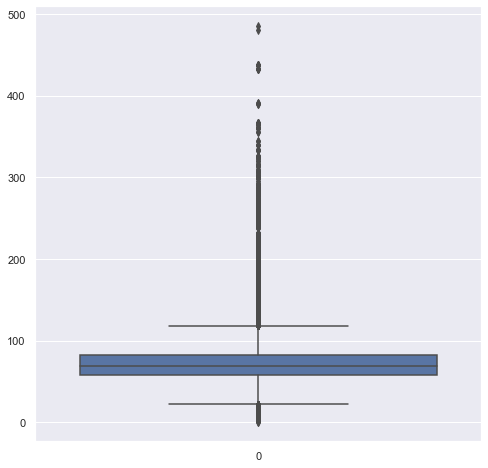

In [145]:
# compute the length of title
titleLength = china_2020.title.apply(lambda x : len(x))

# statistics of `titleLength`
print(titleLength.describe())

sns.set(rc={'figure.figsize':(8,8)})
sns.boxplot(data=titleLength)

Obviously, most titles have fewer than 100 letters, while some are extremely long. 

- By checking the longest title, we find out that it is due to data collection issues. 
- For convenience, we treat these data as outliers and drop them.
- A significant dividing line for removing outliers is around 207, so we can drop all rows with the title length larger than 207.

In [147]:
# find the one with the longest title
print(china_2020.iloc[titleLength.argmax()])

# find the dividing line for removing outliers
print("TitleLength at 0.95: %d" % titleLength.quantile(0.993))
print("TitleLenght at 0.94: %d" % titleLength.quantile(0.992))

# drop outliers
china_2020 = china_2020.loc[titleLength < 207]

quotationOffset                                                    594
quoteID                                              2020-02-01-039806
numOccurrences                                                       1
quotation            So far, we know 361 Bangladeshis of Wuhan have...
leftContext          [QUOTE] January 31, 2020 Leave a comment busin...
rightContext         35 Chinese workers on Padma Bridge project und...
globalTopSpeaker                                        Obaidul Quader
globalProbas                [[Obaidul Quader, 0.7155], [None, 0.2845]]
localTopSpeaker                                         Obaidul Quader
localProbas                 [[Obaidul Quader, 0.7155], [None, 0.2845]]
title                Four persons arrested on charge of gang - rape...
date                                               2020-02-01 00:00:52
articleID                                        2020020100_00011337_W
localTopSpeakerID                                          [Q14325293]
Name: 

We check urls given in the dataset, and realize that they are unreliable. 
- Some urls point to online articles that don't match those given in the dataset. It could be that websites updated these page after they were crawled. 
- Since our project doesn't rely on the information of urls and press media, we decide to drop `url`.

In [14]:
# drop url
china = china.drop(columns=["url"])

In [20]:
# check numbers of names (possible speakers) mentioned
numOfNames = china.names.apply(lambda x: len(x))
numOfNames.value_counts()

1     19034
2     16321
3     12971
4      8202
5      5622
6      3721
7      2069
8      1157
9       723
11      555
10      522
12      267
13      189
14      128
16      128
15      116
18       78
17       66
20       63
19       54
22       39
23       39
25       39
21       39
28       32
27       29
24       21
33       19
30       18
26       17
29       17
31       11
32       10
34        8
43        6
36        5
39        5
35        4
40        3
61        3
46        2
45        2
42        2
38        2
62        2
37        2
72        2
67        2
65        2
78        1
70        1
68        1
52        1
64        1
Name: names, dtype: int64

[Text(0.5, 0, 'date of first four months in 2020'),
 Text(0, 0.5, 'num of articles mentioning china')]

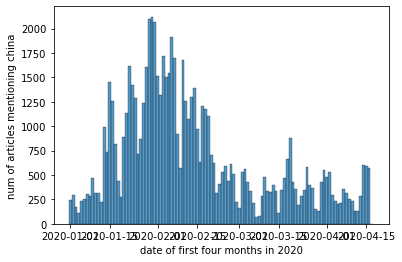

In [26]:
# check the number of articles discussing china over time for the first four months in 2020
sns.histplot(data=china.date.dt.date).set(xlabel="date of first four months in 2020", ylabel="num of articles mentioning china")

We can see a peak around Feburaray, when Covid-19 outbreak in China caught attention.

---

## speaker-attributes


In [29]:
speaker_path = "data/speaker_attributes.parquet"
speaker = pd.read_parquet(speaker_path)

In [28]:
speaker.shape

(9055981, 15)

In [30]:
speaker.head(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [32]:
speaker = speaker.drop_duplicates(subset="id")

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


In [36]:
# check different values of `type``
print(speaker.type.value_counts())

# drop `item` since it is less informative
speaker = speaker.drop(columns="type")

item    9055981
Name: type, dtype: int64


In [41]:
speaker.date_of_birth = speaker.date_of_birth.apply(lambda x: x[0] if x is not None else None)
speaker.gender = speaker.gender.apply(lambda x: x[0] if x is not None else None)
speaker.party = speaker.party.apply(lambda x: x[0] if x is not None else None)

[Text(0, 0, 'male'), Text(1, 0, 'female')]

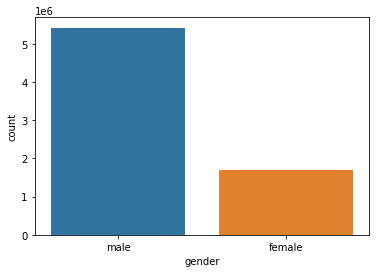

In [79]:
# compare male(Q6581097) and female(Q6581072) speakers
gender_speaker = speaker[(speaker.gender == "Q6581097") | (speaker.gender == "Q6581072")]
sns.countplot(data=gender_speaker, x="gender").set_xticklabels(["male", "female"])



In [75]:
# compare speakers from US(Q30), UK(Q145), AU(Q408), CA(Q16), NZ(Q664)

nations=['Q30','Q145','Q408','Q16','Q664']
speaker1=speaker.explode(column="nationality")
speaker1=speaker1[speaker1['nationality'].isin(nations)]

In [76]:
speaker1.nationality

0           Q30
1          Q145
3           Q30
8           Q16
8           Q30
           ... 
9055974     Q30
9055975     Q30
9055976     Q30
9055977     Q30
9055980     Q30
Name: nationality, Length: 765734, dtype: object

[Text(0, 0, 'US'),
 Text(1, 0, 'UK'),
 Text(2, 0, 'AU'),
 Text(3, 0, 'CA'),
 Text(4, 0, 'NZ')]

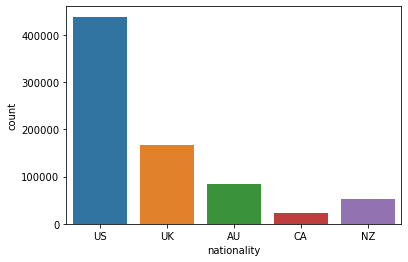

In [78]:
sns.countplot(data=speaker1, x="nationality").set_xticklabels(["US", "UK", "AU", "CA", "NZ"])

In [80]:
# compare speakers who are politicians(Q82955)

speaker2 = speaker.explode(column="occupation")